In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, classification_report, RocCurveDisplay
import shap
import warnings

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8')

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

In [2]:
# ===============================================================
# 1) LOAD DATASETS
# ===============================================================

from pathlib import Path
OUT = Path("../data")
print(OUT)

data = pd.read_csv(OUT / 'Full_dataset_reference.csv', index_col=0, parse_dates=True)

..\data


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4091 entries, 2010-03-15 to 2025-12-04
Data columns (total 44 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   S&P500                             4091 non-null   float64
 1   NASDAQ                             4091 non-null   float64
 2   DowJones                           4091 non-null   float64
 3   CAC40                              4091 non-null   float64
 4   DAX                                4091 non-null   float64
 5   FTSE100                            4091 non-null   float64
 6   Nikkei225                          4091 non-null   float64
 7   HangSeng                           4091 non-null   float64
 8   MSCIWorld                          4091 non-null   float64
 9   US10Y                              4091 non-null   float64
 10  US2Y                               4091 non-null   float64
 11  TLT                                409

In [4]:
print(data.tail(10))

              S&P500    NASDAQ  DowJones     CAC40       DAX   FTSE100  \
Date                                                                     
2025-11-21  0.009823  0.008834  0.010779  0.000198 -0.008032  0.001259   
2025-11-24  0.015467  0.026890  0.004387 -0.002879  0.006379 -0.000503   
2025-11-25  0.009062  0.006715  0.014299  0.008308  0.009701  0.007824   
2025-11-26  0.006907  0.008213  0.006679  0.008800  0.011148  0.008544   
2025-11-27  0.005355  0.006505  0.006100  0.000375  0.001759  0.000237   
2025-11-28  0.000000  0.000000  0.000000  0.002869  0.002896  0.002744   
2025-12-01 -0.005323 -0.003842 -0.008951 -0.003165 -0.010377 -0.001852   
2025-12-02  0.002457  0.005918  0.003915 -0.002765  0.005147 -0.000072   
2025-12-03  0.002980  0.001726  0.008603  0.001586 -0.000723 -0.001000   
2025-12-04  0.001080  0.002177 -0.000667  0.004279  0.007948  0.001940   

            Nikkei225  HangSeng  MSCIWorld     US10Y  ...  \
Date                                              

In [5]:
# ===============================================================
# EXPLORATORY DATA ANALYSIS (EDA) – BINARY CLASSIFICATION
# ===============================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings("ignore")

# ---------------------------------------------------------------
# 1) BASIC INSPECTION
# ---------------------------------------------------------------
print("Shape of dataset:", data.shape)
print("\n--- Data types ---")
print(data.dtypes)

print("\n--- Missing values ---")
print(data.isnull().sum())

print("\n--- First 5 rows ---")
display(data.head())

Shape of dataset: (4091, 44)

--- Data types ---
S&P500                               float64
NASDAQ                               float64
DowJones                             float64
CAC40                                float64
DAX                                  float64
FTSE100                              float64
Nikkei225                            float64
HangSeng                             float64
MSCIWorld                            float64
US10Y                                float64
US2Y                                 float64
TLT                                  float64
IEF                                  float64
BND                                  float64
LQD                                  float64
Apple                                float64
Microsoft                            float64
Google                               float64
Amazon                               float64
Meta                                 float64
Inflation_CPI                        float64
Unempl

,S&P500,NASDAQ,DowJones,CAC40,DAX,FTSE100,Nikkei225,HangSeng,MSCIWorld,US10Y,...,Public_Debt_GDP_Pct,OECD_CPI_2015idx_USA,OECD_Unemp_rate_pct_USA,Return,Volatility_20d,MA20,MA50,Momentum,RSI,Direction
Date,,,,,,,,,,,,,,,,,,,,,
2010-03-15,0.000452,-0.002302,0.001643,-0.009291,-0.006989,-0.005653,0.000067,-0.006159,0.0,-0.001617,...,84.964374,91.67907,9.8,-0.012180,0.012682,0.004875,0.001064,-21.510328,51.075952,1
2010-03-16,0.007779,0.006689,0.004119,0.012347,0.011422,0.004737,-0.002815,-0.002665,0.0,-0.013769,...,84.964374,91.67907,9.8,0.002725,0.012642,0.005011,0.001084,-0.848476,45.971761,0
2010-03-17,0.005822,0.004659,0.004463,0.004808,0.008925,0.004306,0.011684,0.017198,0.0,-0.003011,...,84.964374,91.67907,9.8,-0.001470,0.012552,0.005147,0.001373,-1.180134,47.804194,1
2010-03-18,-0.000326,0.000917,0.004239,-0.004980,-0.001987,-0.000354,-0.009491,-0.002517,0.0,0.008237,...,84.964374,91.67907,9.8,0.002364,0.012546,0.005171,0.001457,-0.194540,47.103415,0
2010-03-19,-0.005086,-0.007055,-0.003450,-0.003235,-0.004970,0.001329,0.007510,0.001882,0.0,0.004085,...,84.964374,91.67907,9.8,-0.010683,0.012797,0.004947,0.001110,-3.189853,41.466841,1



--- Descriptive statistics (numeric features) ---


,count,mean,std,min,25%,50%,75%,max
S&P500,4091.0,4.946914e-04,1.076829e-02,-1.198406e-01,-3.594268e-03,3.907944e-04,5.481249e-03,9.515388e-02
NASDAQ,4091.0,6.428088e-04,1.276034e-02,-1.232133e-01,-4.557937e-03,7.861176e-04,6.973716e-03,1.216316e-01
DowJones,4091.0,4.213905e-04,1.032253e-02,-1.292655e-01,-3.593087e-03,3.795187e-04,5.086397e-03,1.136504e-01
CAC40,4091.0,2.502039e-04,1.218954e-02,-1.227677e-01,-5.367990e-03,3.590277e-04,6.365396e-03,9.659285e-02
DAX,4091.0,4.081215e-04,1.210396e-02,-1.223861e-01,-4.942432e-03,5.314585e-04,6.450564e-03,1.097590e-01
FTSE100,4091.0,1.799992e-04,9.631635e-03,-1.087382e-01,-4.254523e-03,2.605997e-04,4.945675e-03,9.053047e-02
Nikkei225,4091.0,4.655089e-04,1.300098e-02,-1.239576e-01,-5.730631e-03,0.000000e+00,7.103543e-03,1.022633e-01
HangSeng,4091.0,1.315723e-04,1.282340e-02,-1.322335e-01,-6.355807e-03,0.000000e+00,6.677618e-03,9.081796e-02
MSCIWorld,4091.0,4.333521e-04,9.957445e-03,-1.137760e-01,-2.876003e-03,0.000000e+00,4.232847e-03,9.096279e-02
US10Y,4091.0,4.008327e-04,2.767116e-02,-2.932011e-01,-1.247946e-02,0.000000e+00,1.238447e-02,4.989980e-01



--- Target variable distribution ---
Direction
1    0.512589
0    0.487411
Name: proportion, dtype: float64


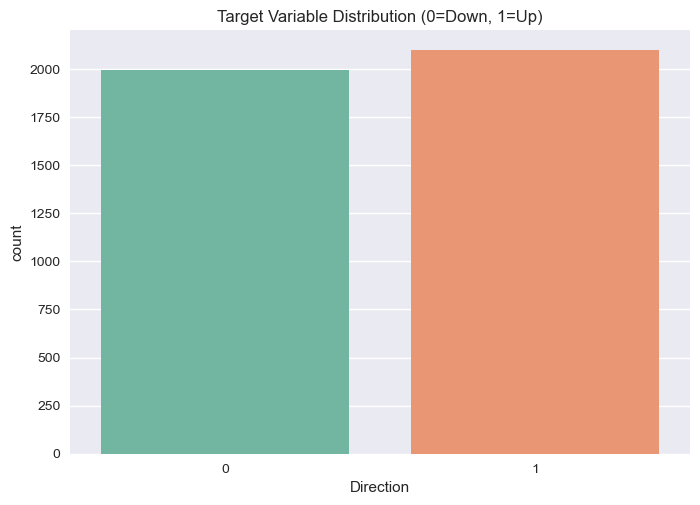

In [7]:
# ---------------------------------------------------------------
# 2) DESCRIPTIVE STATISTICS
# ---------------------------------------------------------------
print("\n--- Descriptive statistics (numeric features) ---")
display(data.describe().T)

# Target variable balance
print("\n--- Target variable distribution ---")
print(data["Direction"].value_counts(normalize=True))
sns.countplot(x="Direction", data=data, palette="Set2")
plt.title("Target Variable Distribution (0=Down, 1=Up)")
plt.show()

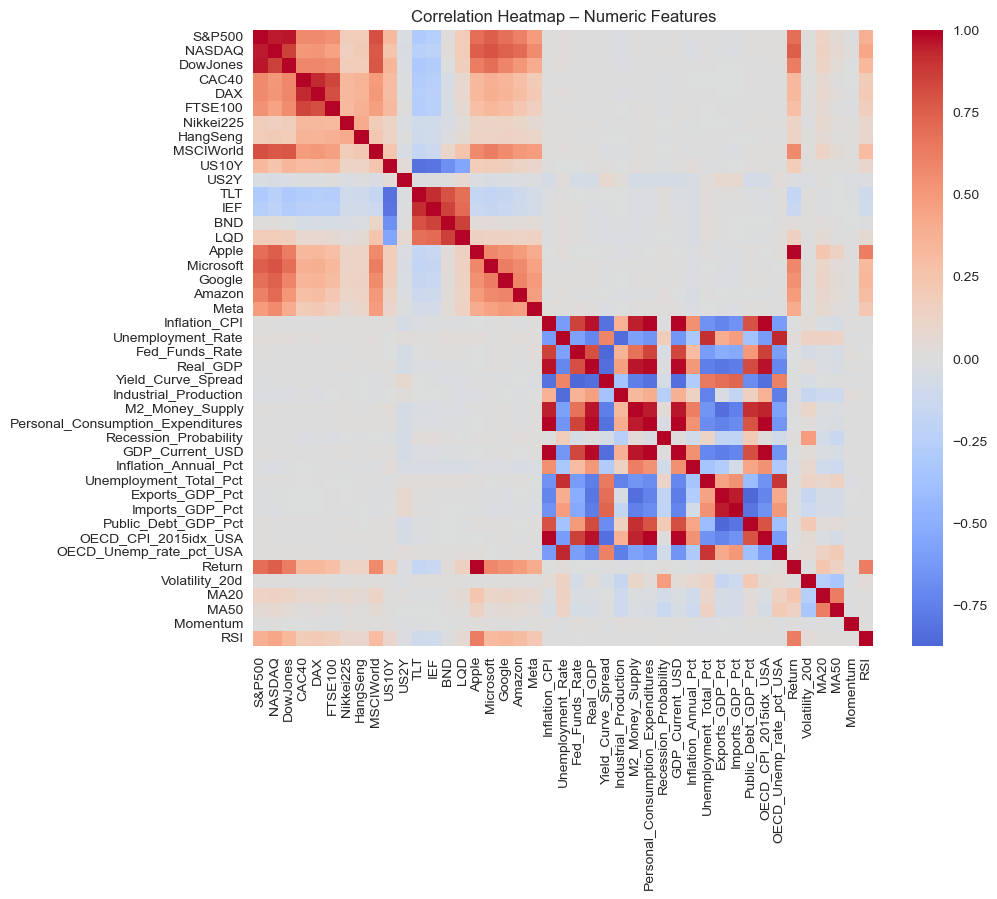


--- Correlation of each feature with Direction ---


Direction                            1.000000
LQD                                  0.040937
HangSeng                             0.038464
Nikkei225                            0.026255
BND                                  0.025654
IEF                                  0.025314
MA20                                 0.023508
TLT                                  0.022634
US2Y                                 0.018265
Fed_Funds_Rate                       0.013655
OECD_Unemp_rate_pct_USA              0.012378
Unemployment_Rate                    0.011777
Personal_Consumption_Expenditures    0.008273
GDP_Current_USD                      0.007939
Real_GDP                             0.007665
Inflation_CPI                        0.006932
OECD_CPI_2015idx_USA                 0.006819
M2_Money_Supply                      0.005367
Public_Debt_GDP_Pct                  0.003751
MA50                                 0.003304
RSI                                  0.000475
FTSE100                           

In [8]:
# ---------------------------------------------------------------
# 3) CORRELATION ANALYSIS
# ---------------------------------------------------------------
numeric_features = data.drop(columns=["Direction"]).select_dtypes(include=[np.number])
corr = numeric_features.corr()

plt.figure(figsize=(10,8))
sns.heatmap(corr, cmap="coolwarm", center=0)
plt.title("Correlation Heatmap – Numeric Features")
plt.show()

# Correlation with target
corr_target = data.corr()["Direction"].sort_values(ascending=False)
print("\n--- Correlation of each feature with Direction ---")
display(corr_target)

In [9]:
# ---------------------------------------------------------------
# 4) OUTLIER DETECTION
# ---------------------------------------------------------------
# Using z-score method
z_scores = np.abs(stats.zscore(numeric_features))
outlier_rows = np.where(z_scores > 3)
print(f"\nNumber of outliers (|z|>3): {len(outlier_rows[0])}")


Number of outliers (|z|>3): 1725


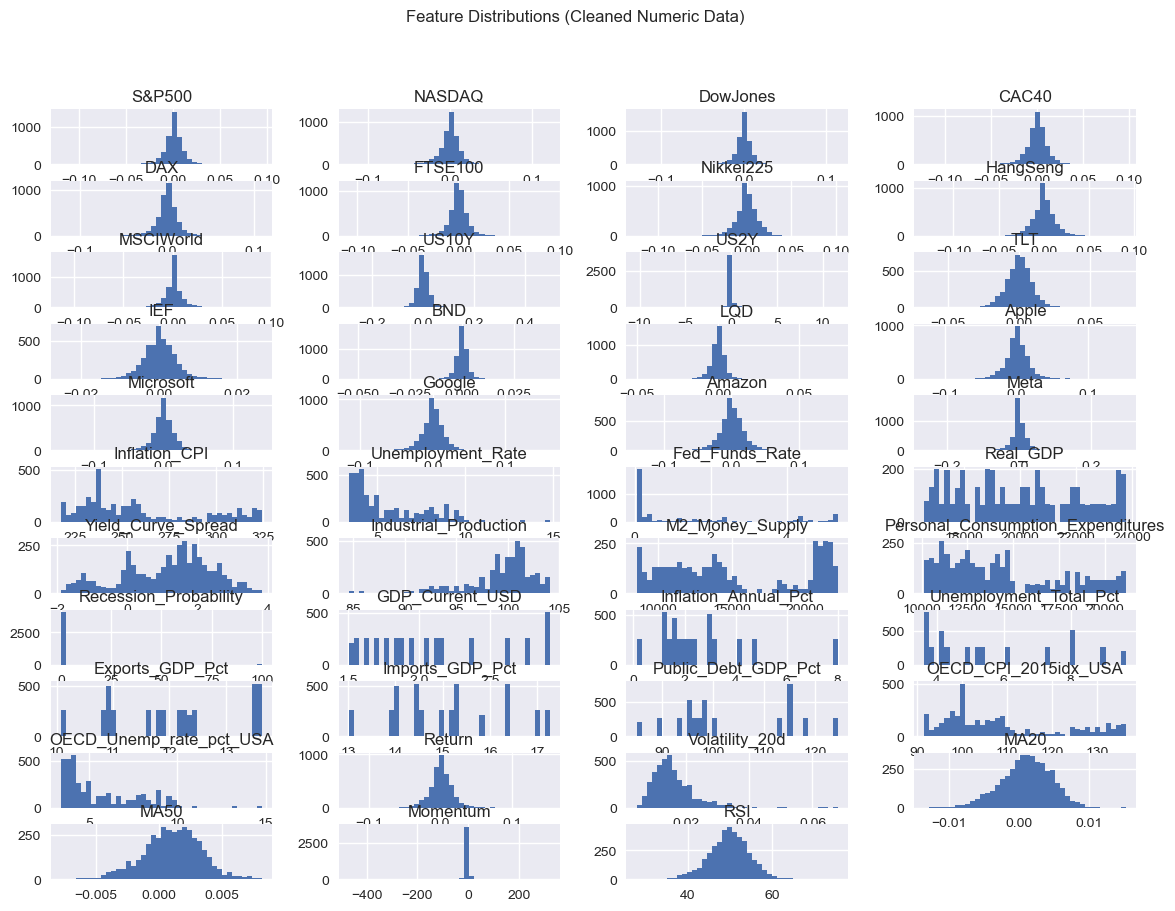

In [10]:
# ---------------------------------------------------------------
# 5) FEATURE DISTRIBUTIONS
# ---------------------------------------------------------------
# ---------------------------------------------------------------
# CLEAN NUMERIC FEATURES BEFORE PLOTTING
# ---------------------------------------------------------------
numeric_features_clean = numeric_features.replace([np.inf, -np.inf], np.nan).dropna(axis=1, how='all')

# Plot histograms only for columns with finite values
numeric_features_clean.hist(
    bins=40,
    figsize=(14,10),
    layout=(int(np.ceil(len(numeric_features_clean.columns)/4)),4)
)
plt.suptitle("Feature Distributions (Cleaned Numeric Data)")
plt.show()

In [11]:
# ---------------------------------------------------------------
# 6) CLEANING AND SCALING – ROBUST VERSION
# ---------------------------------------------------------------

# Replace infinite values and fill missing data
data_clean = data.copy()
numeric_cols = data.drop(columns=["Direction"]).select_dtypes(include=[np.number]).columns

# Replace infinities with NaN
data_clean[numeric_cols] = data_clean[numeric_cols].replace([np.inf, -np.inf], np.nan)

# Fill NaN with median (safer than mean)
data_clean[numeric_cols] = data_clean[numeric_cols].fillna(data_clean[numeric_cols].median())

# Cap extreme outliers to avoid exploding scales
for col in numeric_cols:
    q_low, q_high = data_clean[col].quantile([0.01, 0.99])
    data_clean[col] = data_clean[col].clip(lower=q_low, upper=q_high)

# Standardize numeric features safely
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

data_scaled = data_clean.copy()
data_scaled[numeric_cols] = scaler.fit_transform(data_clean[numeric_cols])

print("\n OK Data cleaned and scaled successfully.")
display(data_scaled.head())


 OK Data cleaned and scaled successfully.


,S&P500,NASDAQ,DowJones,CAC40,DAX,FTSE100,Nikkei225,HangSeng,MSCIWorld,US10Y,...,Public_Debt_GDP_Pct,OECD_CPI_2015idx_USA,OECD_Unemp_rate_pct_USA,Return,Volatility_20d,MA20,MA50,Momentum,RSI,Direction
Date,,,,,,,,,,,,,,,,,,,,,
2010-03-15,-0.002498,-0.249648,0.138054,-0.854086,-0.663930,-0.663189,-0.033835,-0.533965,-0.050012,-0.084336,...,-1.621291,-1.297062,1.920726,-0.829660,-0.488802,1.062615,-0.006361,-3.466830,0.255150,1
2010-03-16,0.772874,0.520252,0.417438,1.084684,0.986877,0.512362,-0.279318,-0.238109,-0.050012,-0.618524,...,-1.621291,-1.297062,1.920726,0.106302,-0.495058,1.100755,0.002406,0.022038,-0.805088,0
2010-03-17,0.565728,0.346475,0.456297,0.409241,0.762965,0.463538,0.955530,1.443451,-0.050012,-0.145617,...,-1.621291,-1.297062,1.920726,-0.157120,-0.508857,1.138672,0.129474,-0.033965,-0.424457,1
2010-03-18,-0.084834,0.025965,0.431035,-0.467797,-0.215427,-0.063718,-0.847875,-0.225585,-0.050012,0.348869,...,-1.621291,-1.297062,1.920726,0.083663,-0.509817,1.145509,0.166562,0.132458,-0.570022,0
2010-03-19,-0.588626,-0.656672,-0.436863,-0.311451,-0.482886,0.126757,0.600073,0.146829,-0.050012,0.166336,...,-1.621291,-1.297062,1.920726,-0.735651,-0.471104,1.082887,0.014010,-0.373317,-1.740847,1



--- Sensitivity (Point-biserial correlation with target) ---


,Correlation,p-value
HangSeng,0.037825,0.015545
LQD,0.036642,0.019093
BND,0.029237,0.061508
MA20,0.024487,0.117362
IEF,0.024272,0.120607
TLT,0.020738,0.184791
Nikkei225,0.018158,0.245577
Fed_Funds_Rate,0.013655,0.382590
OECD_Unemp_rate_pct_USA,0.011915,0.446120
Unemployment_Rate,0.011648,0.456402


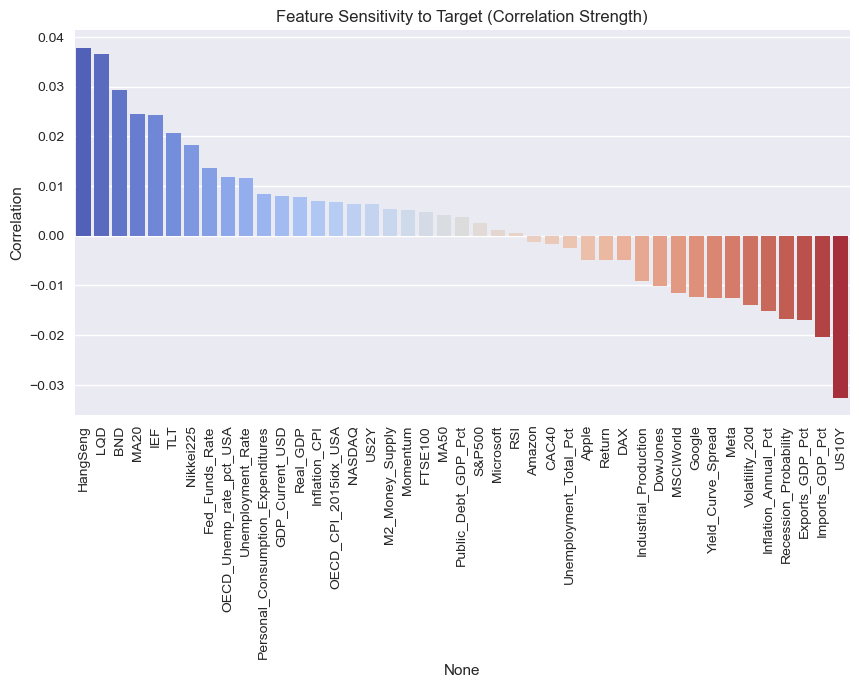

In [12]:
# ---------------------------------------------------------------
# 7) SENSITIVITY ANALYSIS (Feature vs Target)
# ---------------------------------------------------------------
# Point-biserial correlation (numerical vs binary target)
from scipy.stats import pointbiserialr

sensitivity = {}
for col in numeric_features.columns:
    corr_val, p_val = pointbiserialr(data_scaled[col], data_scaled["Direction"])
    sensitivity[col] = [corr_val, p_val]

sensitivity_df = pd.DataFrame(sensitivity, index=["Correlation", "p-value"]).T
sensitivity_df.sort_values("Correlation", ascending=False, inplace=True)

print("\n--- Sensitivity (Point-biserial correlation with target) ---")
display(sensitivity_df)

plt.figure(figsize=(10,5))
sns.barplot(x=sensitivity_df.index, y=sensitivity_df["Correlation"], palette="coolwarm")
plt.xticks(rotation=90)
plt.title("Feature Sensitivity to Target (Correlation Strength)")
plt.show()

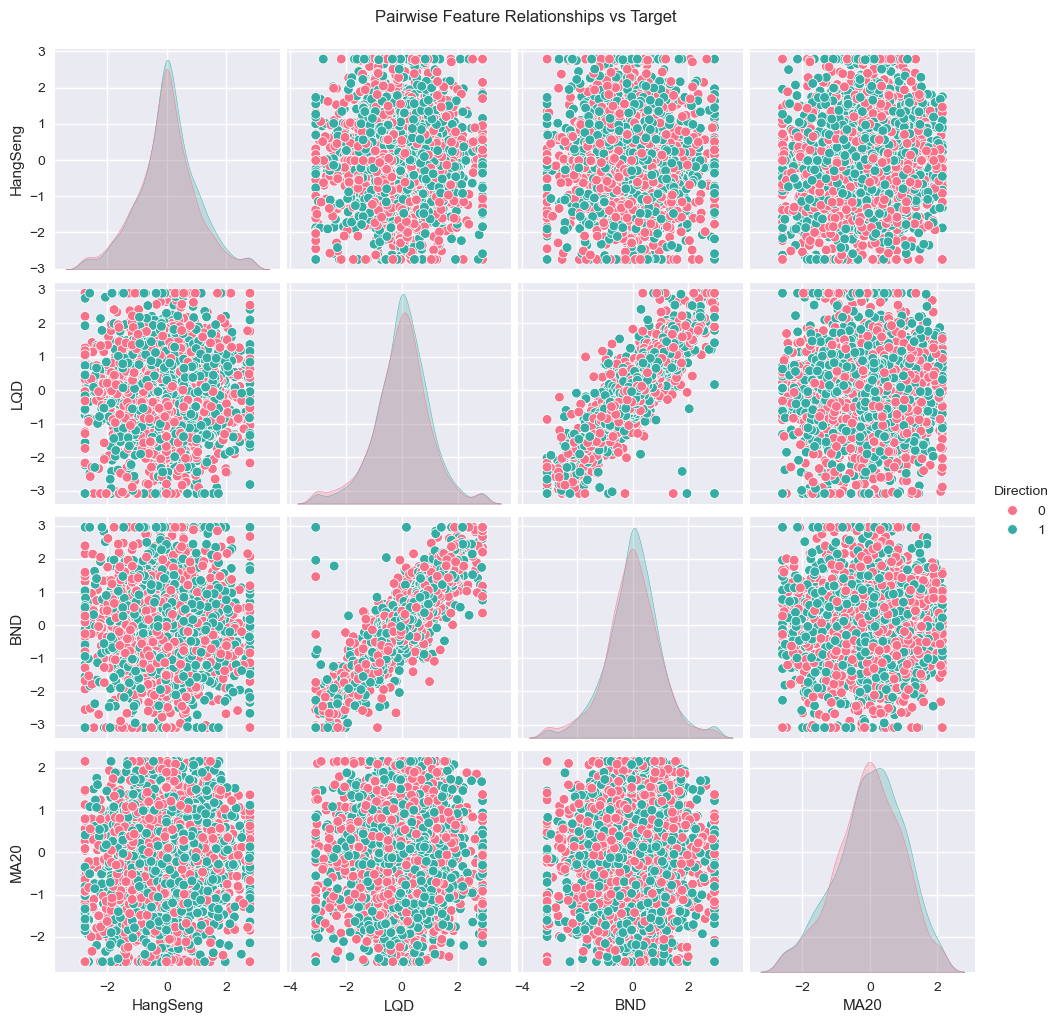

In [13]:
# ---------------------------------------------------------------
# 8) PAIRPLOT FOR VISUAL EXPLORATION
# ---------------------------------------------------------------
sample_cols = ["Direction"] + list(sensitivity_df.index[:4])  # top 4 features
sns.pairplot(data_scaled[sample_cols], hue="Direction", diag_kind="kde", palette="husl")
plt.suptitle("Pairwise Feature Relationships vs Target", y=1.02)
plt.show()

In [46]:
data_scaled.to_csv(OUT / "Cleaned_Features_for_ML.csv")

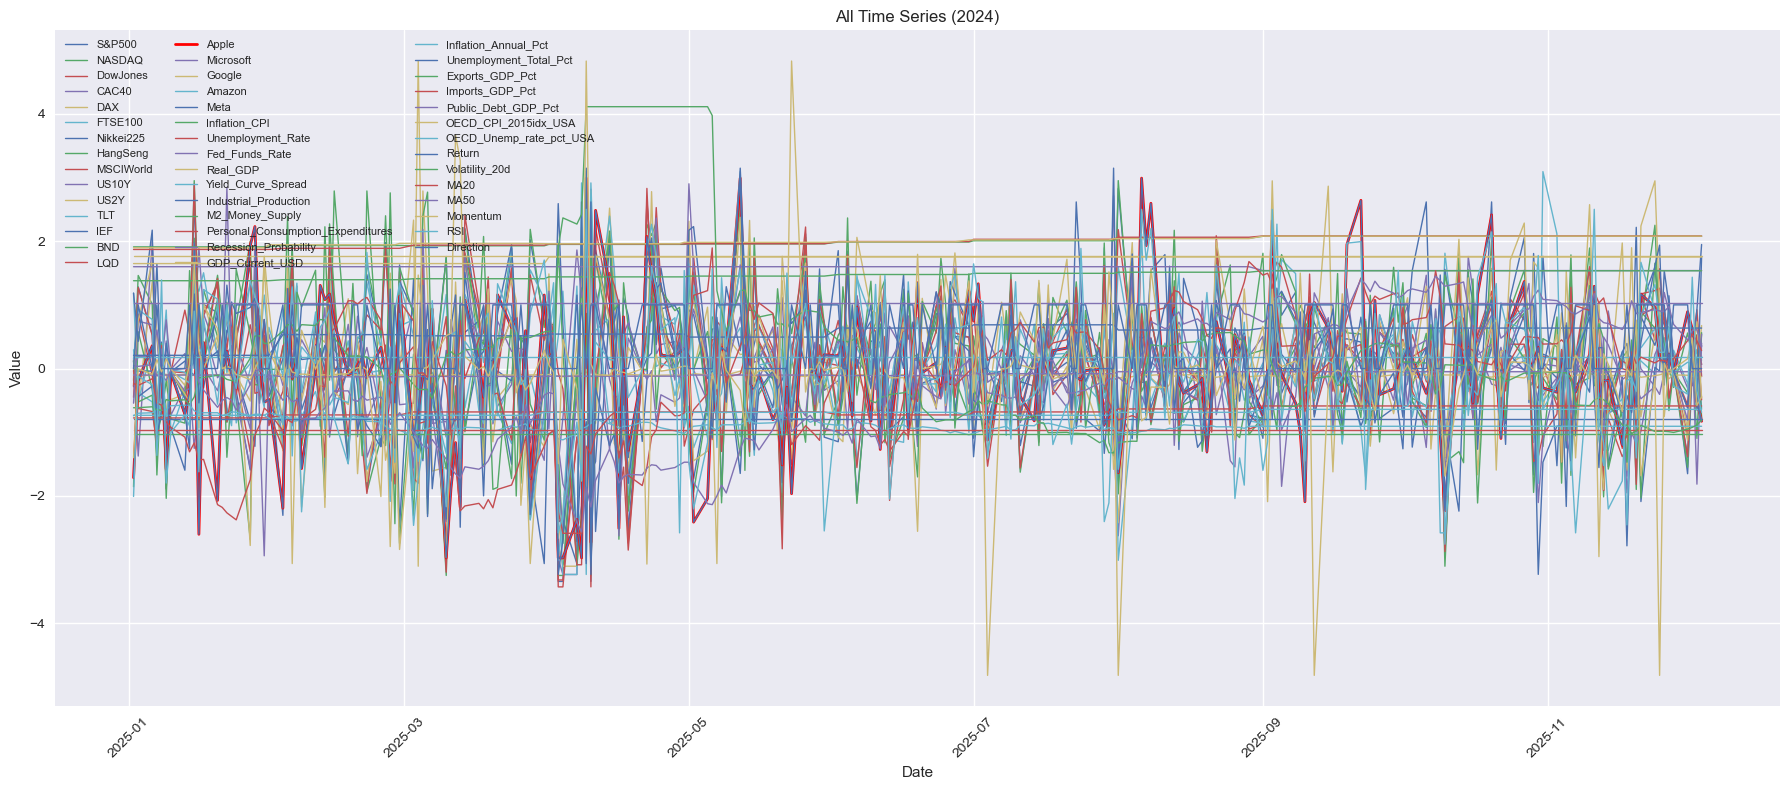

In [14]:
import matplotlib.pyplot as plt

# Restrict to year 2024 only
data_2024 = data_scaled.loc['2025-01-01':'2025-12-31']

plt.figure(figsize=(18, 8))

for col in data_2024.columns:
    if col == "Apple":
        plt.plot(data_2024.index, data_2024[col], label=col, linewidth=2, color='red')
    else:
        plt.plot(data_2024.index, data_2024[col], label=col, linewidth=1)

plt.title("All Time Series (2024)")
plt.xlabel("Date")
plt.ylabel("Value")
plt.legend(loc='upper left', fontsize=8, ncol=3)
plt.grid(True)
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()
